In [1]:
import pickle 
from networkx import draw_networkx_nodes, draw_networkx_edges, draw_networkx, connected_components
import matplotlib.pyplot as plt
import numpy as np
import copy
import json
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from tqdm import tqdm

c:\Users\catta\anaconda3\envs\kernel\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
training_data_path = 'data/training_data.pkl'
test_data_path = 'data/test_data.pkl'
training_labels_path = 'data/training_labels.pkl'

In [3]:
with open(training_data_path, 'rb') as f :
    training_data = pickle.load(f)

with open(training_labels_path, 'rb') as f :
    training_labels = pickle.load(f)

with open(test_data_path, 'rb') as f :
    test_data = pickle.load(f)

In [4]:
print(type(training_data))
print(len(training_data))

<class 'list'>
6000


### Slight overview on nodes

In [5]:
first_mol = training_data[0]
print(first_mol.nodes)

for atom in first_mol.nodes :
    print(first_mol.nodes[atom]['labels'][0], end='-')

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
1-1-2-0-0-1-1-1-1-1-1-1-1-1-1-1-

In [6]:
second_mol = training_data[1]
print(second_mol.nodes)

for atom in second_mol.nodes :
    print(second_mol.nodes[atom]['labels'][0], end='-')

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
1-1-1-1-2-1-1-1-1-1-1-1-2-2-1-1-1-1-1-1-1-1-1-4-

In [7]:
N_preview = 5

for i in range(N_preview) :
    
    mol = training_data[i]
    print(f'{i}-th molecule composed of {len(mol.nodes)} atoms.')

    for atom in first_mol.nodes :
        print(first_mol.nodes[atom]['labels'][0], end='-')
    print('\n ------------')

0-th molecule composed of 16 atoms.
1-1-2-0-0-1-1-1-1-1-1-1-1-1-1-1-
 ------------
1-th molecule composed of 24 atoms.
1-1-2-0-0-1-1-1-1-1-1-1-1-1-1-1-
 ------------
2-th molecule composed of 18 atoms.
1-1-2-0-0-1-1-1-1-1-1-1-1-1-1-1-
 ------------
3-th molecule composed of 33 atoms.
1-1-2-0-0-1-1-1-1-1-1-1-1-1-1-1-
 ------------
4-th molecule composed of 32 atoms.
1-1-2-0-0-1-1-1-1-1-1-1-1-1-1-1-
 ------------


In [8]:
atom_dict = {k:0 for k in range(50)}
molecule_length = []

for i in range(len(training_data)) :
    
    mol = training_data[i]
    molecule_length.append(len(mol.nodes))

    for atom in mol.nodes :
        atom_type = mol.nodes[atom]['labels'][0]
        atom_dict[atom_type]+=1

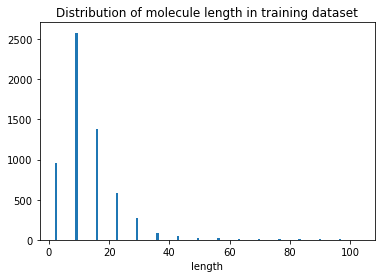

In [9]:
plt.hist(molecule_length, width=0.8, bins=15, align='mid')
plt.title('Distribution of molecule length in training dataset')
plt.xlabel('length')
plt.show()


In [10]:
print(np.mean(molecule_length))
print(np.median(molecule_length))
print(np.quantile(molecule_length, 0.25))
print(np.quantile(molecule_length, 0.75))

16.140333333333334
14.0
10.0
20.0


In [11]:
print(atom_dict)

{0: 15755, 1: 68731, 2: 6900, 3: 1014, 4: 1893, 5: 1316, 6: 277, 7: 98, 8: 293, 9: 106, 10: 0, 11: 25, 12: 36, 13: 239, 14: 1, 15: 7, 16: 8, 17: 20, 18: 1, 19: 6, 20: 0, 21: 11, 22: 3, 23: 2, 24: 3, 25: 1, 26: 3, 27: 4, 28: 38, 29: 0, 30: 1, 31: 5, 32: 9, 33: 7, 34: 3, 35: 1, 36: 1, 37: 4, 38: 1, 39: 4, 40: 1, 41: 3, 42: 1, 43: 1, 44: 3, 45: 2, 46: 1, 47: 1, 48: 1, 49: 1}


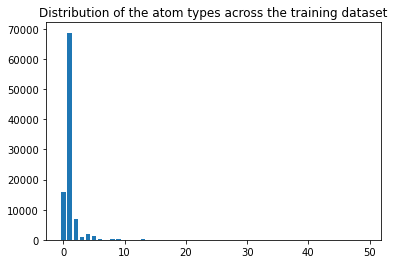

In [12]:
plt.bar(atom_dict.keys(), atom_dict.values(), width= 0.7, align='center')
plt.title('Distribution of the atom types across the training dataset')
plt.show()

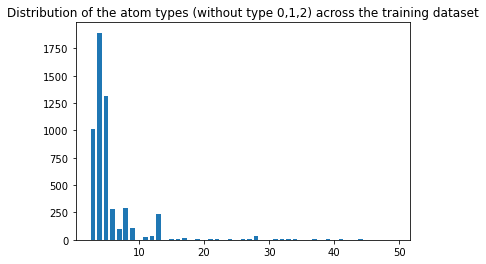

In [13]:
tail_atom_dict = atom_dict
del tail_atom_dict[0]
del tail_atom_dict[1]
del tail_atom_dict[2]
plt.bar(tail_atom_dict.keys(), tail_atom_dict.values(), width= 0.7, align='center')
plt.title('Distribution of the atom types (without type 0,1,2) across the training dataset')
plt.show()

In [14]:
# Check structure of molecule containing atom #47-48-49
for i in range(len(training_data)) :
    
    mol = training_data[i]

    for atom in mol.nodes :
        atom_type = mol.nodes[atom]['labels'][0]
        if atom_type in [47,48,49] :
            for atom in mol.nodes :
                print(mol.nodes[atom]['labels'][0], end='-')
            print('\n')

47-4-4-4-

0-48-0-0-

1-1-1-1-1-1-4-49-



### Slight overview on edges

In [15]:
edges_dict = {k:0 for k in range(4)}

for i in range(len(training_data)) :
    
    mol = training_data[i]
    mol_length = len(mol.nodes)

    edge_list = [(i,j) for i in range(mol_length) for j in range(i+1, mol_length)]

    number_error = 0

    for edge in edge_list :
            try :
                edge_type = mol.edges[edge[0],edge[1]]['labels'][0]
                # edges_dict[edge_type] = edges_dict.get(edge_type, 0) + 1
                edges_dict[edge_type] += 1
            except KeyError as e :
                number_error += 1

print(edges_dict)
print(number_error)

{0: 60228, 1: 8812, 2: 28308, 3: 238}
77


In [16]:
print(f'In the training set, {100*number_error/(sum(edges_dict.values())+number_error):.3f}% of atom bonds do not exist')

In the training set, 0.079% of atom bonds do not exist


### Discovering labels of training data

In [17]:
print(type(training_labels))
print(len(training_labels))
print(set(training_labels))

<class 'numpy.ndarray'>
6000
{0, 1}


In [18]:
print(f"{np.sum(training_labels)}/{len(training_labels)} are positive graphs.")

555/6000 are positive graphs.


In [19]:
def get_all_atom_types(G) :

    atom_types = {}
    for k in G.nodes :
        atom_types[k] = G.nodes[k]['labels'][0]

    return atom_types


def get_atom_type(G, vertex_id) :

    return G.nodes[vertex_id]['labels'][0]



def get_neighbors_id(G, vertex_id) :

    L = []
    neighbored_edges = [k for k in G.edges if vertex_id in k]

    for edge in neighbored_edges :

        if edge[0] != vertex_id :
            L.append(edge[0])
        else : 
            L.append(edge[1])

    return L


def sorted_neighbors_id(G, vertex_id, pattern_dict) :

    """ 
    Returns a dict {neighbors id: neighbors label} sorted by their label

    """
    # Define random but fixed order for labels
    unique_pattern_order = list(pattern_dict.keys())

    # Get a dict of neighbors_id with their label and order it according to the label order ahead
    neighbors_id = get_neighbors_id(G, vertex_id)
    neighbors_dict = {k:str(get_atom_type(G,k)) for k in neighbors_id}

    neighbors_dict_sorted = dict(sorted(neighbors_dict.items(), key=lambda item: unique_pattern_order.index(item[1])))

    return neighbors_dict_sorted


def WL(Graph, max_iter, verbose=False) :

    G = copy.deepcopy(Graph)

    
    feature_vector = {}

    # Initialize feature vector with initial labels
    atom_types = get_all_atom_types(G)
    atom_types_set = set(atom_types.values())

    pattern_dict = {str(pattern):list(atom_types.values()).count(pattern) for pattern in atom_types_set}
    old_pattern_dict_length = len(pattern_dict)
    feature_vector.update(pattern_dict)

    if verbose : 
        print('Pattern dict', pattern_dict)

    # Start iterations
    for iter in range(1, max_iter+1) :
        
        pattern_type = [] 

        for vertex_id in G.nodes :
            
            # Get vertex label
            vertex_type = get_atom_type(G, vertex_id)
            
            # Identify neighbors of current vertex
            neighbors_id = sorted_neighbors_id(G, vertex_id, pattern_dict)
            
            # Identify patterns and fill exhaustively pattern list (with potentially repetition)
            pattern = f'{vertex_type}' + iter*'-' + '>'
            for neighbor in neighbors_id :
                pattern += str(get_atom_type(G, neighbor))
                pattern += (iter-1)*' '
            
            pattern_type.append(pattern)

        for k in range(len(pattern_type)) :

            # Change vertex label (relabelling)
            G.nodes[k]['labels'][0] = pattern_type[k]

        # Count unique patterns  
        pattern_dict = {k:pattern_type.count(k) for k in set(pattern_type)}
        assert sum(pattern_dict.values()) == len(G.nodes)
        
  
        # Stop algorithm if iteration doesn't add information
        if len(pattern_dict) == old_pattern_dict_length :
            break
        else :
            old_pattern_dict_length = len(pattern_dict)
            # Update feature vector
            feature_vector.update(pattern_dict)  
        
        if verbose :
            print(f'Iteration {iter} finished !')
            print('Pattern dict', pattern_dict)
            print('Length of pattern dict', len(pattern_dict))
            print('Feature_vector', feature_vector)

    return feature_vector


def linear_kernel(fv1, fv2) :

    """
    Given two WL embeddings of graph, compute their similarity as the dot product (hence linear kernel)
    ! WARNING ! : only the common patterns are taken into account as this is a dot product.

    """
    s = 0
    for k in fv1 : 
        if k in fv2 : 
            s += fv1[k]*fv2[k]
    
    return s

In [20]:
print(WL(training_data[0], 10, verbose=True))

Pattern dict {'0': 2, '1': 13, '2': 1}
Iteration 1 finished !
Pattern dict {'0->11': 2, '1->12': 3, '1->011': 2, '1->11': 4, '1->1': 2, '1->01': 1, '1->0': 1, '2->111': 1}
Length of pattern dict 8
Feature_vector {'0': 2, '1': 13, '2': 1, '0->11': 2, '1->12': 3, '1->011': 2, '1->11': 4, '1->1': 2, '1->01': 1, '1->0': 1, '2->111': 1}
Iteration 2 finished !
Pattern dict {'1->12-->1->01 2->111 ': 1, '2->111-->1->12 1->12 1->12 ': 1, '0->11-->1->011 1->0 ': 1, '1->12-->1->1 2->111 ': 2, '0->11-->1->011 1->01 ': 1, '1->11-->1->11 1->11 ': 2, '1->11-->1->011 1->11 ': 2, '1->1-->1->12 ': 2, '1->011-->0->11 1->011 1->11 ': 2, '1->0-->0->11 ': 1, '1->01-->0->11 1->12 ': 1}
Length of pattern dict 11
Feature_vector {'0': 2, '1': 13, '2': 1, '0->11': 2, '1->12': 3, '1->011': 2, '1->11': 4, '1->1': 2, '1->01': 1, '1->0': 1, '2->111': 1, '1->12-->1->01 2->111 ': 1, '2->111-->1->12 1->12 1->12 ': 1, '0->11-->1->011 1->0 ': 1, '1->12-->1->1 2->111 ': 2, '0->11-->1->011 1->01 ': 1, '1->11-->1->11 1->11 

In [21]:
mol_id = 10
embedding = WL(training_data[mol_id], 10)
print(json.dumps(embedding, indent=1))

{
 "0": 8,
 "1": 16,
 "2": 3,
 "1->12": 6,
 "1->2": 1,
 "1->11": 2,
 "1->1": 2,
 "1->022": 1,
 "1->0111": 1,
 "1->001": 3,
 "0->1": 8,
 "2->111": 3,
 "0->1-->1->0111 ": 1,
 "1->12-->1->1 2->111 ": 2,
 "1->001-->1->0111 0->1 0->1 ": 1,
 "1->12-->1->12 2->111 ": 4,
 "2->111-->1->12 1->12 1->2 ": 1,
 "1->11-->1->0111 1->001 ": 2,
 "1->1-->1->12 ": 2,
 "1->022-->0->1 2->111 2->111 ": 1,
 "2->111-->1->12 1->12 1->022 ": 2,
 "1->2-->2->111 ": 1,
 "0->1-->1->001 ": 6,
 "0->1-->1->022 ": 1,
 "1->0111-->1->11 1->11 1->001 0->1 ": 1,
 "1->001-->1->11 0->1 0->1 ": 2,
 "2->111-->1->12 1->12 1->022 --->1->12-->1->12 2->111   1->12-->1->12 2->111   1->022-->0->1 2->111 2->111   ": 1,
 "1->2-->2->111 --->2->111-->1->12 1->12 1->2   ": 1,
 "0->1-->1->001 --->1->001-->1->11 0->1 0->1   ": 4,
 "2->111-->1->12 1->12 1->022 --->1->12-->1->1 2->111   1->12-->1->1 2->111   1->022-->0->1 2->111 2->111   ": 1,
 "1->001-->1->11 0->1 0->1 --->1->11-->1->0111 1->001   0->1-->1->001   0->1-->1->001   ": 2,
 "0->1

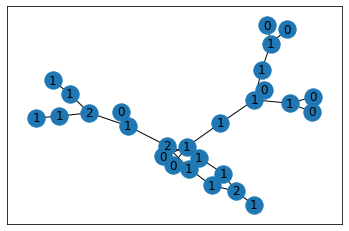

In [22]:
draw_networkx(training_data[mol_id], labels=get_all_atom_types(training_data[mol_id]))

In [23]:
N = 100
gram = np.zeros((N,N))
fv = []

start = time.time()
for k in range(N) :
    fv.append(WL(training_data[k], max_iter=5))

for i in range(N) :
    for j in range(i, N) :
        gram[i,j] = linear_kernel(fv[i],fv[j])

end = time.time()

print(gram)
print(end-start)

[[ 306.  322.  211. ...  325.  607.  767.]
 [   0.  678.  328. ...  566. 1091. 1330.]
 [   0.    0.  248. ...  330.  582.  759.]
 ...
 [   0.    0.    0. ...  675. 1043. 1380.]
 [   0.    0.    0. ...    0. 2436. 2582.]
 [   0.    0.    0. ...    0.    0. 3666.]]
0.32692909240722656


## Working on how to discard unconnected subgraphs inside graph

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13} {14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}


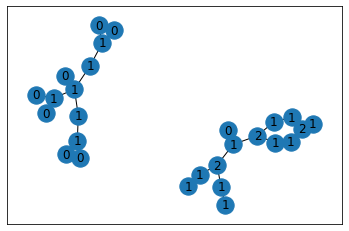

In [24]:
mol_id = 10
print(*connected_components(training_data[mol_id]))
draw_networkx(training_data[mol_id], labels=get_all_atom_types(training_data[mol_id]))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}


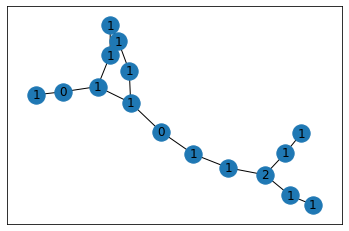

In [25]:
mol_id = 0
print(*connected_components(training_data[mol_id]))
draw_networkx(training_data[mol_id], labels=get_all_atom_types(training_data[mol_id]))

In [26]:
unconnected_graphs = 0
training_unconnected_ids = []
for mol in range(len(training_data)) :
    if len(list(connected_components(training_data[mol]))) > 1 :
        unconnected_graphs += 1
        training_unconnected_ids.append(mol)

print(f'{unconnected_graphs}/{len(training_data)} unconnected graphs inside training set.')
# print(unconnected_ids)

975/6000 unconnected graphs inside training set.


In [27]:
unconnected_graphs = 0
test_unconnected_ids = []
for mol in range(len(test_data)) :
    if len(list(connected_components(test_data[mol]))) > 1 :
        unconnected_graphs += 1
        test_unconnected_ids.append(mol)

print(f'{unconnected_graphs}/{len(test_data)} unconnected graphs inside test set.')
# print(unconnected_ids)

498/2000 unconnected graphs inside test set.


In [28]:
label_count = 0
for k in training_unconnected_ids :
    label_count += training_labels[k]

print(f'{label_count}/{len(training_unconnected_ids)} = {label_count/len(training_unconnected_ids)}')
print(f'Original ratio of positive labels = {np.sum(training_labels)/len(training_labels)}')

78/975 = 0.08
Original ratio of positive labels = 0.0925


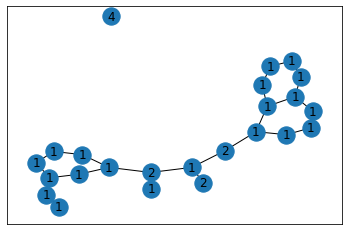

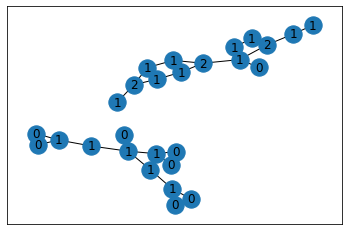

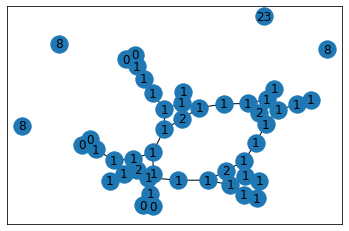

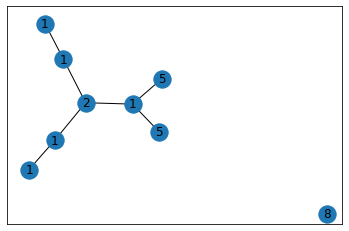

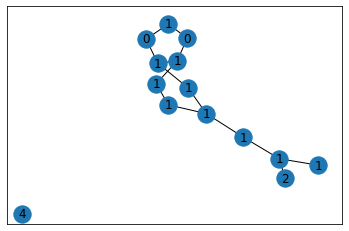

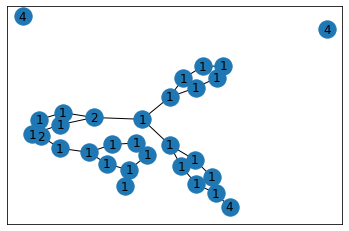

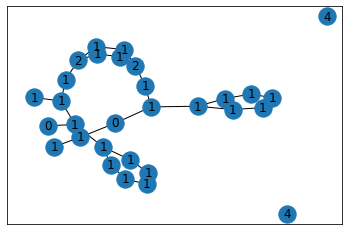

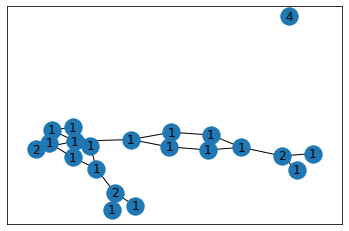

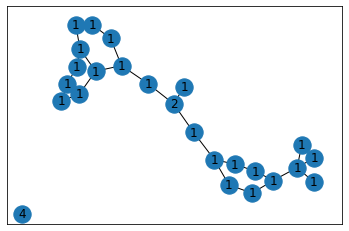

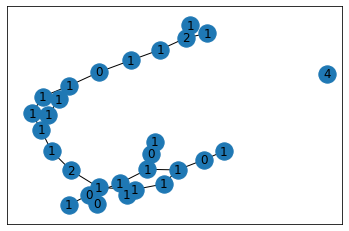

In [29]:
# Checking that we duly identifed unconnected graphs
for k in training_unconnected_ids[:10] :
    plt.figure(k)
    draw_networkx(training_data[k], labels=get_all_atom_types(training_data[k]))
    
plt.show()

## Try k-NN based on WL subtree representation of graphs

In [30]:
training_rate = 0.7
cut_idx = int(len(training_data)*training_rate)
kNN_training_set, kNN_validation_set = training_data[:cut_idx], training_data[cut_idx:]

fv_kNN = []
for k in range(len(kNN_training_set)) :
    fv_kNN.append(WL(kNN_training_set[k], max_iter=5))

In [31]:
def compute_distance_between_dict(fv1, fv2, dist_type='l2') :
    
    dist = 0

    if dist_type == 'l2' :
        for k in fv1 : 
            if k in fv2 : 
                dist += (fv1[k]-fv2[k])**2
            else :
                dist += (fv1[k])**2
        for k in fv2 :
            if k not in fv1 :
                dist += (fv2[k])**2

        return np.sqrt(dist)
    
    elif dist_type == 'l1' :
        for k in fv1 : 
            if k in fv2 : 
                dist += np.abs(fv1[k]-fv2[k])
            else :
                dist += np.abs(fv1[k])
        for k in fv2 :
            if k not in fv1 :
                dist += np.abs(fv2[k])

        return dist


def kNN(G, fv, k=3) :
    """
    Given a graph G whose label is to be predicted, the WL feature vector of the graphs in the training set 
    and the number of nearest neighbors k, returns the predicted label of G.
    """
    G_fv = WL(G, max_iter=5)

    distance_to_train = []

    for i in range(len(fv)) :
        distance_to_train.append(compute_distance_between_dict(G_fv, fv[i], dist_type='l2'))

    k_idx = np.argpartition(distance_to_train, k)[:k]
    is_positive = sum([training_labels[i] for i in k_idx])
    
    if is_positive > k/2 :
        return 1
    else :
        return 0



y_pred = []
y_true= []

for i in range(len(kNN_validation_set)) : 
    y_pred.append(kNN(kNN_validation_set[i], fv_kNN, k=3))
    y_true.append(training_labels[cut_idx+i])


In [32]:
print(len(y_pred))
y_pred_arr = np.array(y_pred)
y_true_arr = np.array(y_true)
misclassified = sum(np.abs(y_pred_arr-y_true_arr))

print(misclassified/len(y_pred))

1800
0.042777777777777776


In [33]:
print(sum(y_true_arr))
print(sum(y_pred_arr))

48
67


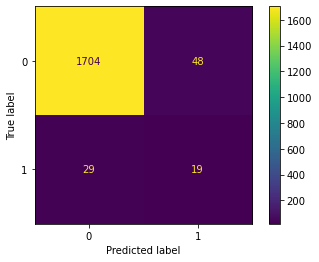

0.6842180365296804


In [34]:
cm = confusion_matrix(y_true_arr, y_pred_arr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,)
disp.plot()
plt.show()

fpr, tpr, _ = roc_curve(y_true_arr, y_pred_arr)
print(auc(fpr,tpr))

## Kernel Ridge Regression

In [35]:
def gaussian_kernel(fv1, fv2, sigma=0.1) :

    """
    Given two WL embeddings of graph, compute their similarity as the RBF kernel

    """
    vec_diff = []

    for k in fv1 : 
        if k in fv2 : 
            vec_diff.append((fv1[k]-fv2[k])**2)
        else :
            vec_diff.append((fv1[k])**2)
    for k in fv2 :
        if k not in fv1 :
            vec_diff.append((fv2[k])**2)

    return np.exp(-sum(vec_diff)/(2*sigma**2))
    

In [36]:
# Initialize Gram matrix
G = np.zeros((len(kNN_training_set), len(kNN_training_set)))

# Get list of all WL representation of molecules
fv_kRR = copy.deepcopy(fv_kNN)

# Fill the gram matrix with the Gaussian kernel defined above
start = time.time()

for i in range(G.shape[0]) :
    for j in range(i, G.shape[0]) :
        G[i,j] = gaussian_kernel(fv_kRR[i], fv_kRR[j], sigma=0.1)

end = time.time()

print(end-start)


222.67939448356628


In [42]:
# Get labels vector
N = len(kNN_training_set)
y_kRR_labels = np.zeros(N)
for i in range(N) : 
    y_kRR_labels[i] = 2*training_labels[i] - 1

# Compute alpha 
lmbda = 1
alpha_kRR = np.linalg.inv(G + lmbda*N*np.eye(N)) @ y_kRR_labels

In [43]:
# Some stats on alpha
print(sum(alpha_kRR))
print(min(alpha_kRR))
print(max(alpha_kRR))

-0.7583513135521147
-0.00023815187347349132
0.00023809522460420068


In [44]:
# Predict labels of validation set
kRR_prediction = []
for i in tqdm(range(len(kNN_validation_set[:50]))) : 
    Gram_vector = np.array([gaussian_kernel(WL(kNN_validation_set[i], max_iter=5), training_mol) for training_mol in fv_kRR])

    kRR_prediction.append(np.sign(np.dot(alpha_kRR, Gram_vector)))

kRR_prediction_vec = np.array(kRR_prediction)

100%|██████████| 50/50 [03:58<00:00,  4.77s/it]


In [45]:
print(kRR_prediction_vec)

[-1. -1. -1.  0.  0.  0.  0.  0. -1. -1. -1. -1.  0. -1.  0.  0.  0. -1.
  1.  0.  0.  0.  0.  0. -1.  0.  0. -1. -1. -1.  0.  0. -1.  0. -1.  0.
 -1.  0. -1.  0. -1.  1.  0. -1. -1. -1.  0. -1.  1.  1.]


[-1 -1 -1 ... -1 -1 -1]


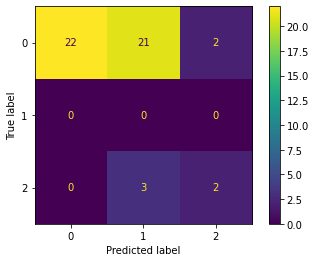

0.8244444444444444


In [46]:
# rescale true labels
y_true_kRR = 2*y_true_arr - 1
print(y_true_kRR)

cm = confusion_matrix(y_true_kRR[:50], kRR_prediction_vec)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,)
disp.plot()
plt.show()

fpr, tpr, _ = roc_curve(y_true_kRR[:50], kRR_prediction_vec)
print(auc(fpr,tpr))